### Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc

In [2]:
from read import read_datasets, get_subsets
datasets = read_datasets()
list(datasets.keys())

['oversampled_normalized',
 'undersampled_normalized',
 'undersampled',
 'oversampled',
 'normalClass',
 'normalClass_normalized']

### Logistic Regression

#### Define testing functions

In [3]:
from sklearn.linear_model import LogisticRegression
def runLR(dataset_name, threshold, subset = []):
    assert dataset_name in datasets

    X_train, X_test, y_train, y_test = get_subsets(datasets[dataset_name])

    y_train = [int(val > threshold) for val in y_train]
    y_test = [int(val > threshold) for val in y_test]

    if subset:
        assert any(c in X_train.columns for c in subset)
        X_train = X_train[[c for c in subset if c in X_train.columns]]
        X_test = X_test[[c for c in subset if c in X_test.columns]]
    
    model = LogisticRegression(max_iter = 10000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return y_pred, y_test, acc, f1

def test_diff_datasets_and_threshold(subset = []):
    results = {
        "dataName":[],
        "featureSubset":[],
        "threshold":[],
        "acc":[],
        "f1":[]
    }
    for name in datasets:
        for t in range(3,8):
            _, _, acc, f1 = runLR(name, t, subset)
            results["dataName"].append(name)
            results["featureSubset"].append(["_".join(sorted(subset))])
            results["threshold"].append(t)
            results["acc"].append(acc)
            results["f1"].append(f1)
    return pd.DataFrame(results).sort_values(by = "f1", ascending=False).reset_index(drop = True)

def getCombos(dataName, drop = []):
    X_train, _, _, _ = get_subsets(datasets[dataName])

    cols = list(X_train.columns)
    if drop:
        cols = [c for c in cols if c not in drop]
    assert cols

    combos = []
    for i in range(1, len(cols) + 1):
        combos.extend(combinations(cols, i))
    
    return combos

dropCols = ["free sulfur dioxide", "pH", "sulfur", "citric acid", "volatile acidity"]

dfOut = pd.DataFrame
for combo in tqdm(getCombos("normalClass", dropCols), desc = "Subset Testing"):
    result = test_diff_datasets_and_threshold(combo)
    if dfOut.empty:
        dfOut = result
    else:
        dfOut = pd.concat([dfOut, result])
dfOut

Subset Testing: 100%|██████████| 127/127 [00:53<00:00,  2.38it/s]


,dataName,featureSubset,threshold,acc,f1
0,normalClass_normalized,[fixed acidity],3,0.996875,0.998435
1,normalClass,[fixed acidity],3,0.996875,0.998435
2,normalClass,[fixed acidity],4,0.956250,0.977636
3,normalClass_normalized,[fixed acidity],4,0.956250,0.977636
4,undersampled_normalized,[fixed acidity],3,0.916667,0.956522
...,...,...,...,...,...
25,undersampled_normalized,[alcohol_chlorides_density_fixed acidity_resid...,6,0.416667,0.222222
26,undersampled_normalized,[alcohol_chlorides_density_fixed acidity_resid...,7,0.833333,0.000000
27,undersampled,[alcohol_chlorides_density_fixed acidity_resid...,7,0.666667,0.000000
28,normalClass,[alcohol_chlorides_density_fixed acidity_resid...,7,0.993750,0.000000


In [4]:
bestPerDataNameThresh = dfOut.groupby(["dataName","threshold"], as_index=False).apply(lambda x: x.nlargest(1, columns='f1')).reset_index(drop = True)
bestPerDataNameThresh

,dataName,featureSubset,threshold,acc,f1
0,normalClass,[fixed acidity],3,0.996875,0.998435
1,normalClass,[fixed acidity],4,0.956250,0.977636
2,normalClass,[alcohol_fixed acidity],5,0.734375,0.736842
3,normalClass,[alcohol_fixed acidity_total sulfur dioxide],6,0.896875,0.297872
4,normalClass,[fixed acidity],7,0.993750,0.000000
5,normalClass_normalized,[fixed acidity],3,0.996875,0.998435
6,normalClass_normalized,[fixed acidity],4,0.956250,0.977636
7,normalClass_normalized,[alcohol_chlorides_density_fixed acidity_resid...,5,0.740625,0.744615
8,normalClass_normalized,[density_fixed acidity_residual sugar_sulphates],6,0.893750,0.392857
9,normalClass_normalized,[fixed acidity],7,0.993750,0.000000


#### Identify Optimal Threshold For Logistic Regression

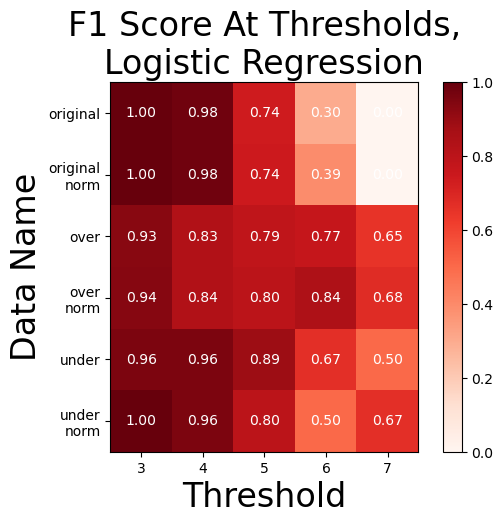

In [5]:
heatmap = []
for name in bestPerDataNameThresh["dataName"].unique():
    heatmap.append(list(bestPerDataNameThresh[bestPerDataNameThresh["dataName"] == name]["f1"]))

heatmap = np.array(heatmap)
plt.imshow(heatmap, cmap='Reds')

plt.xticks(ticks=[0,1,2,3,4], labels=[3,4,5,6,7])
plt.yticks(ticks=[0,1,2,3,4,5],
           labels=["original","original\nnorm","over","over\nnorm","under","under\nnorm"])

plt.xlabel("Threshold", fontsize = 24)
plt.ylabel("Data Name", fontsize = 24)
plt.title("F1 Score At Thresholds,\nLogistic Regression", fontsize =24)

for i in range(6):
    for j in range(5):
        plt.text(j, i, f'{heatmap[i, j]:.2f}', ha='center', va='center', color='white')


plt.colorbar()
plt.show()

#### Get Confusion Matrix at Optimal Threshold

In [6]:
thresh = 5
def plotConfMat(modelName, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.imshow(cm, cmap='Reds')

    plt.xticks(ticks=[0,1], labels=["Low","High"])
    plt.yticks(ticks=[0,1], labels=["Low","High"])

    plt.xlabel("Predicted", fontsize = 24)
    plt.ylabel("Gold", fontsize = 24)
    plt.title(f"Conf. Mat. of Original Data,\n{modelName}, Threshold=5", fontsize =24)

    for i in range(2):
        for j in range(2):
            col = "white" if (i+j)%2 == 0 else "black"
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color=col, fontsize = 24)


    plt.colorbar()
    plt.show()

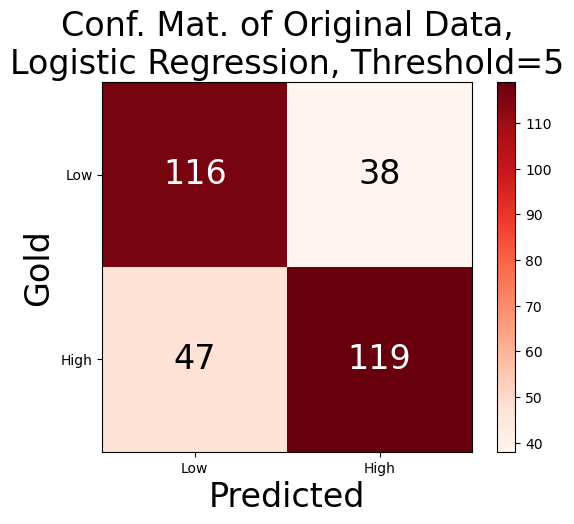

In [7]:
subset = bestPerDataNameThresh[(bestPerDataNameThresh["dataName"] == "normalClass") &\
                                (bestPerDataNameThresh["threshold"] == thresh)].iloc[0,1][0]\
                                .split("_")
y_pred, y_test, acc, f1 = runLR("normalClass", thresh, subset)
plotConfMat("Logistic Regression", y_test, y_pred)

### LDA and QDA

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

X_train, X_test, y_train, y_test = get_subsets(datasets["normalClass"])

y_train = [int(val > thresh) for val in y_train]
y_test = [int(val > thresh) for val in y_test]

if subset:
    assert any(c in X_train.columns for c in subset)
    X_train = X_train[[c for c in subset if c in X_train.columns]]
    X_test = X_test[[c for c in subset if c in X_test.columns]]

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

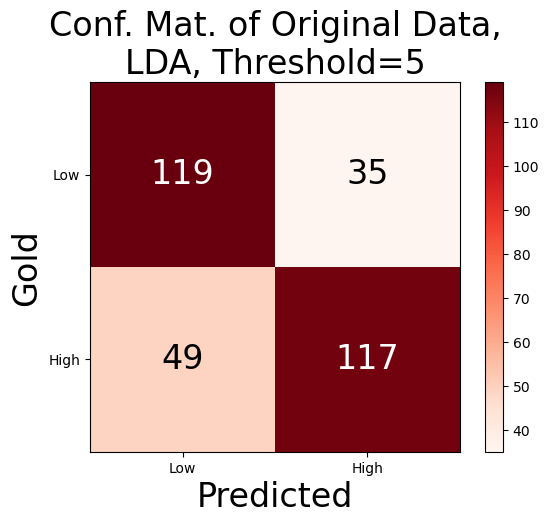

In [9]:
plotConfMat("LDA", y_test, lda.predict(X_test))

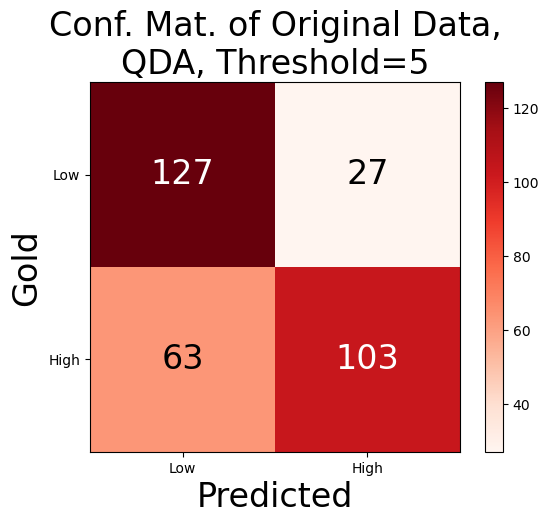

In [10]:
plotConfMat("QDA", y_test, qda.predict(X_test))

### SVM

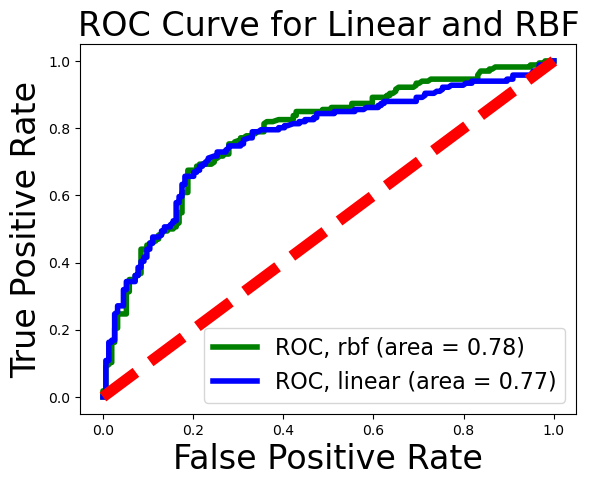

In [11]:
from sklearn.svm import SVC

rbf = SVC(kernel='rbf', probability=True, random_state=1).fit(X_train, y_train)
lin = SVC(kernel='linear', probability=True, random_state=1).fit(X_train, y_train)

plt.figure()

for col, m, name in zip(["green","blue"],[rbf, lin], ["rbf","linear"]):
    fpr, tpr, thresholds = roc_curve(y_test, m.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=col, lw=4, label=f'ROC, {name} (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='red', lw=8, linestyle='--')
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.title('ROC Curve for Linear and RBF', fontsize = 24)
plt.legend(loc='lower right', fontsize = 16)
plt.show()

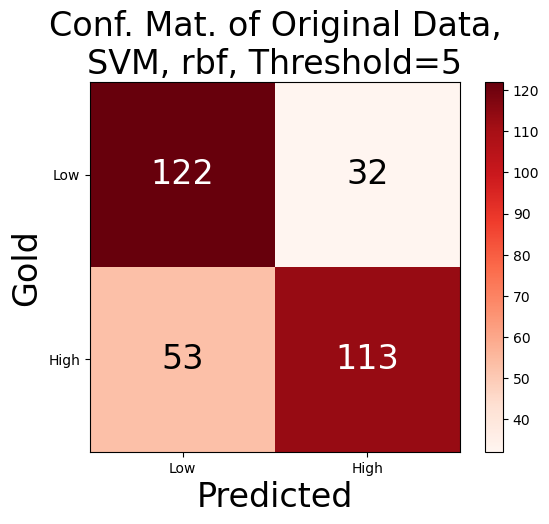

In [12]:
plotConfMat("SVM, rbf", y_test, rbf.predict(X_test))

### Neural Net

In [1]:
library(ISLR)
library(gam)
library(splines)
library(tidyverse)
library(caret)
library(dplyr)
library(nnet)
library(ROCR)

Warning message:
"package 'gam' was built under R version 4.1.2"
Loading required package: splines

Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.1.2"
Loaded gam 1.22-2


Warning message:
"package 'tidyverse' was built under R version 4.1.2"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.1
v tidyr   1.2.0     v stringr 1.5.0
v readr   2.1.2     v forcats 0.5.2
Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Warning message:
"package 'tibble' was built under R version 4.1.2"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'purrr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.2"
Warning message:
"package 'stringr' was built under R version 4.1.2"
Warnin

In [2]:
df <- read.csv("data/normalClass.csv", header = T)
df$quality <- ifelse(df$quality > 5, 1, 0)

train <- subset(df, train_test == "train")
train$train_test <- NULL

test <- subset(df, train_test == "test")
test$train_test <- NULL

dim(train)
dim(test)

[1] 1279   12

[1] 320  12

In [3]:
hl_sizes <- c()
aucs <- c()

for(i in 2:25){
    model <- nnet(quality ~ ., data = train, size = i, skip = F, act.fct = "logistic", maxit = 5000)
    predictions <- prediction(predict(model, newdata = test, type = "r"), test$quality)

    hl_sizes <- append(hl_sizes, i)
    aucs <- append(aucs, performance(predictions, "auc")@y.values[[1]])
}

# weights:  27
initial  value 321.137237 
iter  10 value 294.987965
iter  20 value 266.546247
iter  30 value 240.109557
iter  40 value 234.775707
iter  50 value 231.004090
iter  60 value 226.256898
iter  70 value 222.524541
iter  80 value 220.661587
iter  90 value 219.278783
iter 100 value 218.880844
iter 110 value 218.872498
iter 120 value 218.872179
iter 130 value 218.871776
iter 140 value 218.852959
final  value 218.852681 
converged
# weights:  40
initial  value 314.287105 
iter  10 value 291.747502
iter  20 value 286.046984
iter  30 value 241.665790
iter  40 value 235.623462
iter  50 value 221.314226
iter  60 value 219.055650
iter  70 value 218.887763
final  value 218.872397 
converged
# weights:  53
initial  value 308.211700 
iter  10 value 259.310461
iter  20 value 236.958758
iter  30 value 222.103263
iter  40 value 219.127966
iter  50 value 218.885232
iter  60 value 218.741782
iter  70 value 215.892015
iter  80 value 214.528698
iter  90 value 213.881613
iter 100 value 213.61535

In [4]:
results <- data.frame(hiddenSize = hl_sizes, AUC = aucs)
results <- results[order(-results$AUC), ]
model <- nnet(quality ~ ., data = train, size = results[1,1], skip = F, act.fct = "logistic", maxit = 5000)

head(results)

# weights:  261
initial  value 491.185542 
iter  10 value 284.434978
iter  20 value 263.256341
iter  30 value 240.939613
iter  40 value 221.922495
iter  50 value 202.372015
iter  60 value 199.787392
iter  70 value 195.626119
iter  80 value 191.895013
iter  90 value 189.689361
iter 100 value 187.739361
iter 110 value 185.084760
iter 120 value 183.616564
iter 130 value 182.873406
iter 140 value 182.619145
iter 150 value 182.233780
iter 160 value 181.839001
iter 170 value 181.593910
iter 180 value 180.644963
iter 190 value 179.925405
iter 200 value 178.537164
iter 210 value 177.568877
iter 220 value 177.230547
iter 230 value 177.041682
iter 240 value 176.955435
iter 250 value 176.843398
iter 260 value 176.833297
iter 270 value 176.804824
iter 280 value 176.740341
iter 290 value 176.684873
iter 300 value 176.624203
iter 310 value 176.577360
iter 320 value 176.552516
iter 330 value 176.527803
iter 340 value 176.473181
iter 350 value 176.412857
iter 360 value 176.380098
iter 370 value 176.28

,hiddenSize,AUC
,<int>,<dbl>
19,20,0.8316382
16,17,0.8306212
15,16,0.8299562
9,10,0.8274527
22,23,0.8258488
6,7,0.8251056


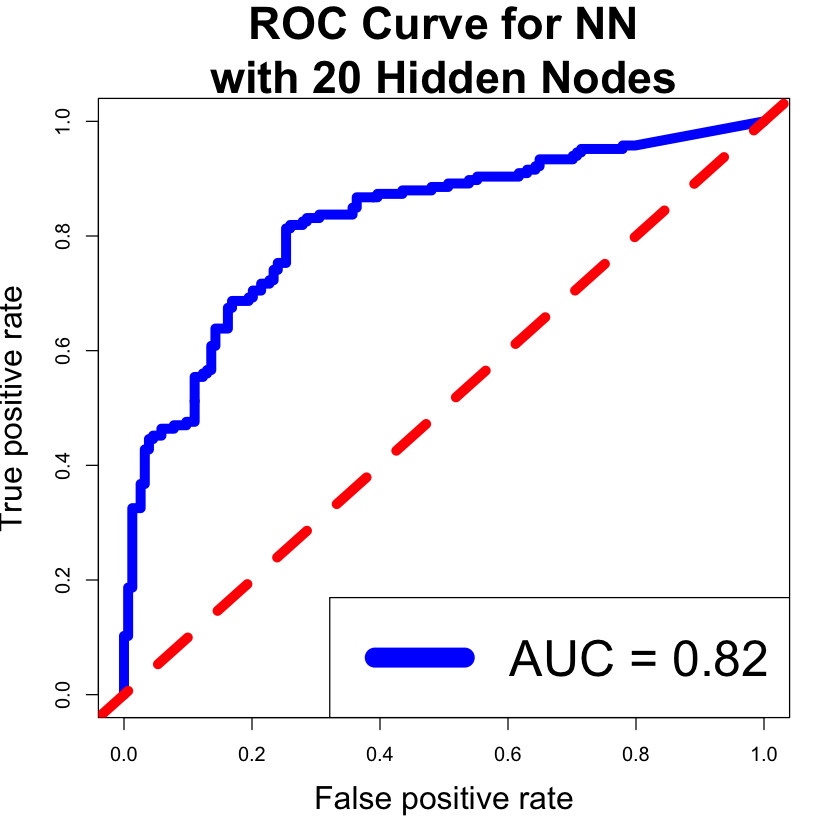

In [5]:
predictions <- prediction(predict(model, newdata = test, type = "r"), test$quality)
perf <- performance(predictions, "tpr", "fpr")
auc <- performance(predictions, "auc")

# Plot ROC curve
plot(perf, main = paste("ROC Curve for NN\nwith",results[1,1],"Hidden Nodes"), col = "blue", lwd = 8, cex.main = 2.25, cex.lab = 1.6)

abline(a = 0, b = 1, lty = 2, col = "red", lwd = 8)  # Add diagonal line for reference
legend("bottomright", legend = paste("AUC =", round(unlist(slot(auc, "y.values")), 2)), col = "blue", lwd = 16, cex = 2.5)


In [6]:
predDf <- data.frame(pred = predict(model, newdata = test, type = "r"), gold = test$quality)
write.csv(predDf, "ClassificationOutput/preds.csv", row.names = F)

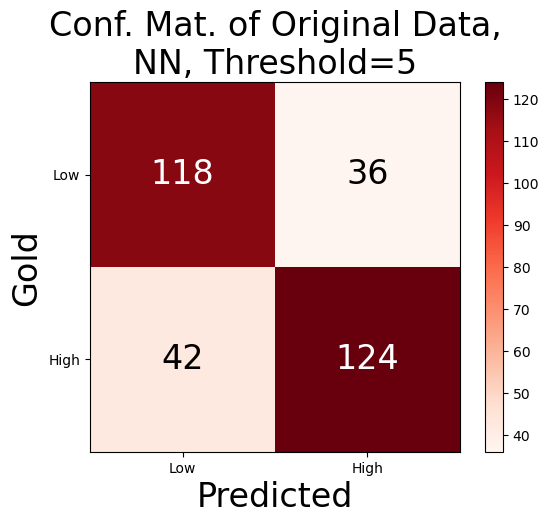

In [12]:
with open("ClassificationOutput/preds.csv", "r") as f:
    NN_preds = pd.read_csv(f)
    NN_preds["pred"] = [int(v >= 0.5) for v in list(NN_preds["pred"])]

plotConfMat("NN", NN_preds["gold"], NN_preds["pred"])